# <center> Prediction of Credit Card Default using K-Nearest Neighbor, Naïve Bayes, Logistic Regression </center>

## Table of Content
I. [Introduction](#into)

II. [Import & load data](#import-load)

III. [Preprocessing](#preprocessing)

IV. [Predictive model](#predictive-model)

V. [Comparaison](#comparaison)

VI. [Conclusion](#conclusion)

VII. [References](#ref)

## I. [Introduction](#intro)

This notebook was created by Mohamed SERHIR in november 2020.
The goal of this notebook is to predict if a customer is likely to default, and discover which variables are good predictors of default.

## II. [Import libraries & load data](#import-load)

In [3]:
#Import libraries

import pandas as pd 
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve

# 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#Normalisation / Standardization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.utils import resample 
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import learning_curve, validation_curve

import joblib

In [4]:
file = "dataset.xls"

In [5]:
data = pd.read_excel(file, header=[1])
data.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# III. Preprocessing

In [6]:
# Let's start with a clean data set 
df = data.copy()

#### We saw that there is no null value and the categories in this data set are represented by numbers (from 0 to 6 in some features), but the categorical data need to be encoded into binary values (0 or 1).

In [7]:
continuous_vars = ['LIMIT_BAL', 'AGE', 'BILL_AMT_1', 'BILL_AMT_2', 'BILL_AMT_3', 'BILL_AMT_4', 'BILL_AMT_5', 'BILL_AMT_6', 'PAY_AMT_1', 'PAY_AMT_2', 'PAY_AMT_3', 'PAY_AMT_4', 'PAY_AMT_5', 'PAY_AMT_6']
discrete_vars = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
pay_delay_vars = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_vars = ['BILL_AMT_1', 'BILL_AMT_2', 'BILL_AMT_3', 'BILL_AMT_4', 'BILL_AMT_5', 'BILL_AMT_6']
pay_amt_vars = ['PAY_AMT_1', 'PAY_AMT_2', 'PAY_AMT_3', 'PAY_AMT_4', 'PAY_AMT_5', 'PAY_AMT_6']

## 1) Rename columns and delete useless var (ID)

In [8]:
# Column ID is useless
df = df.drop('ID', axis=1)

In [9]:
#Renaming
df = df.rename(columns={'PAY_0': 'PAY_1',
                       'BILL_AMT1' : 'BILL_AMT_1', 'BILL_AMT2' : 'BILL_AMT_2',
                       'BILL_AMT3' : 'BILL_AMT_3', 'BILL_AMT4' : 'BILL_AMT_4',
                       'BILL_AMT5' : 'BILL_AMT_5', 'BILL_AMT6' : 'BILL_AMT_6',
                       'PAY_AMT1' : 'PAY_AMT_1', 'PAY_AMT2' : 'PAY_AMT_2',
                       'PAY_AMT3' : 'PAY_AMT_3', 'PAY_AMT4' : 'PAY_AMT_4',
                       'PAY_AMT5' : 'PAY_AMT_5', 'PAY_AMT6' : 'PAY_AMT_6',
                       'default payment next month' : 'DPNM'})
df.head(0)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT_1,BILL_AMT_2,BILL_AMT_3,BILL_AMT_4,BILL_AMT_5,BILL_AMT_6,PAY_AMT_1,PAY_AMT_2,PAY_AMT_3,PAY_AMT_4,PAY_AMT_5,PAY_AMT_6,DPNM


## 2) Categorical features

`SEX`: Gender (1 = male; 2 = female).  
`EDUCATION`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).  
`MARRIAGE`: Marital status (1 = married; 2 = single; 3 = others).  

---
`SEX`: Gender (1 = male; 2 = female) to 0 = male; 1 = female

In [10]:
df.SEX.value_counts().sort_index()

1    11888
2    18112
Name: SEX, dtype: int64

In [11]:
#df.loc[df['SEX'] == 1, 'SEX'] = 0
#df.loc[df['SEX'] == 2, 'SEX'] = 1

In [12]:
df['SEX'].replace([1,2], [0,1], inplace=True)

In [13]:
df.SEX.value_counts().sort_index()

0    11888
1    18112
Name: SEX, dtype: int64

In [14]:
df.DPNM.value_counts().sort_index()

0    23364
1     6636
Name: DPNM, dtype: int64

---
`EDUCATION`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).  

In [12]:
df.EDUCATION.value_counts().sort_index()

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

In [13]:
## We do not have any information about 0, 5 and 6. So let's put it in the category "others"

 #df.loc[df['EDUCATION'] == 0, 'EDUCATION'] = 4
 #df.loc[df['EDUCATION'] == 5, 'EDUCATION'] = 4
 #df.loc[df['EDUCATION'] == 6, 'EDUCATION'] = 4

## Then start from 0
 #df.loc[df['EDUCATION'] == 1, 'EDUCATION'] = 0
 #df.loc[df['EDUCATION'] == 2, 'EDUCATION'] = 1
 #df.loc[df['EDUCATION'] == 3, 'EDUCATION'] = 2
 #df.loc[df['EDUCATION'] == 4, 'EDUCATION'] = 3

df['EDUCATION'].replace([0,1,2,3,4,5,6], [3,0,1,2,3,3,3], inplace=True)

In [14]:
df.EDUCATION.value_counts().sort_index()

0    10585
1    14030
2     4917
3      468
Name: EDUCATION, dtype: int64

---
`MARRIAGE`: Marital status (1 = married; 2 = single; 3 = others).

In [15]:
df.MARRIAGE.value_counts().sort_index()

0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64

In [16]:
# We have no information about "0", it will be with "others"
df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3
#Then start from 0
df.loc[df['MARRIAGE'] == 1, 'MARRIAGE'] = 0
df.loc[df['MARRIAGE'] == 2, 'MARRIAGE'] = 1
df.loc[df['MARRIAGE'] == 3, 'MARRIAGE'] = 2


- The "others" variable is not usefull for our case study, let's transform singer by "not married" and regroup single + others

In [17]:
df['MARRIAGE'].replace([2], [1], inplace=True)

In [18]:
df.MARRIAGE.value_counts().sort_index()

0    13659
1    16341
Name: MARRIAGE, dtype: int64

---

`PAY_x`: the repayment status in x_month, 2005.   
-> The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

In [19]:
pay_df = pd.DataFrame()
for col in pay_delay_vars:
    pay_df = pay_df.append(df[col].value_counts())
    #print(str(df[col].value_counts().sort_index()))
pay_df

,-2,-1,0,1,2,3,4,5,6,7,8
PAY_1,2759.0,5686.0,14737.0,3688.0,2667.0,322.0,76.0,26.0,11.0,9.0,19.0
PAY_2,3782.0,6050.0,15730.0,28.0,3927.0,326.0,99.0,25.0,12.0,20.0,1.0
PAY_3,4085.0,5938.0,15764.0,4.0,3819.0,240.0,76.0,21.0,23.0,27.0,3.0
PAY_4,4348.0,5687.0,16455.0,2.0,3159.0,180.0,69.0,35.0,5.0,58.0,2.0
PAY_5,4546.0,5539.0,16947.0,NaN,2626.0,178.0,84.0,17.0,4.0,58.0,1.0
PAY_6,4895.0,5740.0,16286.0,NaN,2766.0,184.0,49.0,13.0,19.0,46.0,2.0


-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

Pay_X variables can take 11 differents encoded categories, but our machine learning methods are sensitive to the orders relation (-2 < -1 < 0 ...), we are going to use the one-hot encoding.

## 3. Baseline Model

In [20]:
# Creating target and features for X and y
target = 'DPNM'
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE' ] + pay_delay_vars + bill_vars + pay_amt_vars

X = df.drop([target], axis=1)
y = df[target]
print(X.shape)
print(y.shape)


(30000, 23)
(30000,)


### Creation of train and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Train set: ', X_train.shape)
print('Test set:', X_test.shape)

Train set:  (24000, 23)
Test set: (6000, 23)


In [22]:
%%time
model_baseline = KNeighborsClassifier(n_neighbors = 2)

model_baseline.fit(X_train, y_train)
model_baseline.score(X_test, y_test)

Wall time: 736 ms


0.7656666666666667

In [23]:
%%time
model_baseline_ = GaussianNB()

model_baseline_.fit(X_train, y_train)
model_baseline_.score(X_test, y_test)

Wall time: 31 ms


0.36483333333333334

## 4) One hot Encoding

We have 3 or more categories in the categorical values.. It's already encoded but not binary encoded

In [24]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT_1,BILL_AMT_2,BILL_AMT_3,BILL_AMT_4,BILL_AMT_5,BILL_AMT_6,PAY_AMT_1,PAY_AMT_2,PAY_AMT_3,PAY_AMT_4,PAY_AMT_5,PAY_AMT_6,DPNM
0,20000,1,1,0,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,1,1,1,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,1,1,1,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,1,1,0,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,0,1,0,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,0,2,0,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,0,2,1,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,0,1,1,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,0,2,0,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [25]:
df_enc = pd.get_dummies(df, columns=['EDUCATION',  'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], drop_first=True)

In [26]:
df_enc

,LIMIT_BAL,SEX,MARRIAGE,AGE,BILL_AMT_1,BILL_AMT_2,BILL_AMT_3,BILL_AMT_4,BILL_AMT_5,BILL_AMT_6,PAY_AMT_1,PAY_AMT_2,PAY_AMT_3,PAY_AMT_4,PAY_AMT_5,PAY_AMT_6,DPNM,EDUCATION_1,EDUCATION_2,EDUCATION_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,1,0,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,120000,1,1,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,90000,1,1,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,1,0,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,50000,0,0,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,0,0,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29996,150000,0,1,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29997,30000,0,1,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29998,80000,0,0,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In order to avoid the trap od dummies variables, we are using drop_first = True that drop the first column for each feature encoding

In [27]:
# Encoded train set and test set
X_enc = df_enc.drop([target], axis=1)
y_enc = df_enc[target]

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.2, random_state = 0)
print('Train set: ', X_train_enc.shape)
print('Test set:', X_test_enc.shape)

Train set:  (24000, 77)
Test set: (6000, 77)


In [28]:
%%time
model_baseline_2 = KNeighborsClassifier(n_neighbors = 5)
model_baseline_2.fit(X_train_enc, y_train_enc)
model_baseline_2.score(X_test_enc, y_test_enc)

Wall time: 2.26 s


0.7623333333333333

In [29]:
%%time
model_baseline_2_ = GaussianNB()
model_baseline_2_.fit(X_train_enc, y_train_enc)
model_baseline_2_.score(X_test_enc, y_test_enc)

Wall time: 77.9 ms


0.353

## 5) Normalisation / Standardisation

In [30]:
%%time

## MIN MAX
X_train_minmax = X_train_enc.copy()
X_test_minmax = X_test_enc.copy()

for i in X_train_minmax:
    minmaxScaler = MinMaxScaler().fit(X_train_enc[[i]])
    
    X_train_minmax[i] = minmaxScaler.transform(X_train_enc[[i]])
    X_test_minmax[i] = minmaxScaler.transform(X_test_enc[[i]])

#X_train_minmax
#X_test_minmax

## STANDARD
X_train_std = X_train_enc.copy()
X_test_std = X_test_enc.copy()

for i in continuous_vars:
    standardScaler = StandardScaler().fit(X_train_enc[[i]])
    X_train_std[i] = standardScaler.transform(X_train_enc[[i]])
    X_test_std[i] = standardScaler.transform(X_test_enc[[i]])

#X_train_std
#X_test_std

## ROBUST
X_train_rob = X_train_enc.copy()
X_test_rob = X_test_enc.copy()

for i in continuous_vars:
    robustScaler = RobustScaler().fit(X_train_enc[[i]])
    X_train_rob[i] = robustScaler.transform(X_train_enc[[i]])
    X_test_rob[i] = robustScaler.transform(X_test_enc[[i]])

#X_train_rob
#X_test_rob

Wall time: 637 ms


In [31]:
%%time
## Result check with MinMax Scaler
model_baseline_3 = KNeighborsClassifier(n_neighbors = 5)
model_baseline_3.fit(X_train_minmax, y_train)
print('KNN score with one hot encoding & minmax scaler: ',
      model_baseline_3.score(X_test_minmax, y_test))

model_baseline_3_ = GaussianNB()
model_baseline_3_.fit(X_train_std, y_train)
print('Naive bayes score with one hot encoding & minmax scaler: ',
      model_baseline_3_.score(X_test_std, y_test))
print("--")
## Result check with Standard Scaler
model_baseline_4 = KNeighborsClassifier(n_neighbors = 5)
model_baseline_4.fit(X_train_std, y_train)
print('KNN score with one hot encoding & standard scaler: ',
      model_baseline_4.score(X_test_std, y_test))

model_baseline_4_ = GaussianNB()
model_baseline_4_.fit(X_train_std, y_train)
print('Naive bayes score with one hot encoding & standard scaler: ',
      model_baseline_4_.score(X_test_std, y_test))
print("--")
## Result check with Robust Scaler
model_baseline_5 = KNeighborsClassifier(n_neighbors = 5)
model_baseline_5.fit(X_train_rob, y_train)
print('KNN score with one hot encoding & robust scaler: ',
      model_baseline_5.score(X_test_rob, y_test))

model_baseline_5_ = GaussianNB()
model_baseline_5_.fit(X_train_rob, y_train)
print('Naive Bayes score with one hot encoding & robust scaler: ',
      model_baseline_5_.score(X_test_rob, y_test))

KNN score with one hot encoding & minmax scaler:  0.7951666666666667
Naive bayes score with one hot encoding & minmax scaler:  0.8066666666666666
--
KNN score with one hot encoding & standard scaler:  0.7995
Naive bayes score with one hot encoding & standard scaler:  0.8066666666666666
--
KNN score with one hot encoding & robust scaler:  0.797
Naive Bayes score with one hot encoding & robust scaler:  0.8066666666666666
Wall time: 36.5 s


## 5) Dimensionality Reduction

## PCA

In [32]:
%%time
# Without standardisation
pca = PCA()
pca.fit_transform(X)
pca.explained_variance_ratio_


# With one hot encoding
pca_2 = PCA()
pca_2.fit_transform(X_enc)
pca_2.explained_variance_ratio_

# With encoding & scaling
pca_3 = PCA()
pca_3.fit_transform(X_train_minmax)
pca_3.explained_variance_ratio_

# With encoding & scaling
pca_4 = PCA()
pca_4.fit_transform(X_train_std)
pca_4.explained_variance_ratio_

# With encoding & scaling
pca_5 = PCA()
pca_5.fit_transform(X_train_rob)
pca_5.explained_variance_ratio_
print()


Wall time: 1.77 s


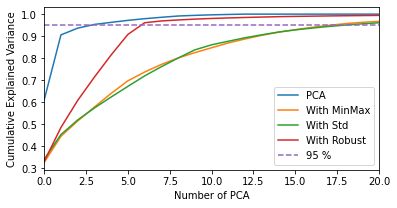

In [33]:
# Plot PCA
plt.figure(figsize=(6,3))

plt.plot(np.cumsum(pca_2.explained_variance_ratio_), label = 'PCA')
plt.plot(np.cumsum(pca_3.explained_variance_ratio_), label = 'With MinMax')
plt.plot(np.cumsum(pca_4.explained_variance_ratio_), label = 'With Std')
plt.plot(np.cumsum(pca_5.explained_variance_ratio_), label = 'With Robust')

plt.plot([0.95] * 21, label='95 %', ls='--')
plt.xlim(0,20)
plt.xlabel('Number of PCA')
plt.ylabel('Cumulative Explained Variance')
plt.legend()

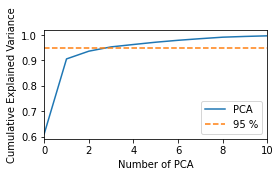

In [34]:
# Plot PCA
plt.figure(figsize=(4,2))

plt.plot(np.cumsum(pca_2.explained_variance_ratio_), label = 'PCA')

plt.plot([0.95] * 11, label='95 %', ls='--')
plt.xlim(0,10)
plt.xlabel('Number of PCA')
plt.ylabel('Cumulative Explained Variance')
plt.legend()

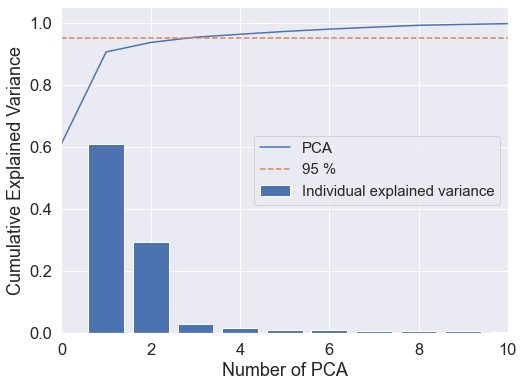

In [112]:
# Plot PCA
plt.figure(figsize=(8,6))
var_pca = pca_2.explained_variance_ratio_
plt.plot(np.cumsum(var_pca), label = 'PCA')
plt.bar(range(1,len(var_pca)+1) , var_pca , alpha=1, align='center', label='Individual explained variance')

plt.plot([0.95] * 11, label='95 %', ls='--')
plt.xlim(0,10)
plt.xlabel('Number of PCA')
plt.ylabel('Cumulative Explained Variance')
plt.legend( loc='center right', fontsize=15)

---

## LDA

Accuracy for LDA : 0.82


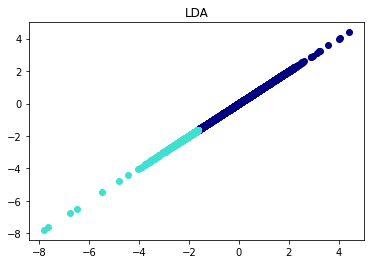

LinearDiscriminantAnalysis()

In [36]:
def lda(x_train, y_train, x_test):
    lda = LDA()
    X_lda = lda.fit(X_train, y_train).transform(x_test)
    y_predict_lda = lda.predict(X_test) 
    accuracy = np.round(np.sum(y_test == y_predict_lda)/len(y_test),3)
    print("Accuracy for LDA :", accuracy)
    #Plot :
    target_names  = [0,1]
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    plt.figure()
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X_lda[y_predict_lda == i, 0], X_lda[y_predict_lda == i, 0], color=color)

    plt.title('LDA')

    plt.show()
    return lda
lda(X_train, y_train, X_test)

---

## 6) Imbalanced Data

In [113]:
## Divide the data set into a majority class and a minority 
def GetMajorityMinority(X, y):
    # Merging X_train and y_train
    df = X.join(y)
    #print(df.DPNM.value_counts())
    
    # Creation of two dataframe (78 % / 22%)
    majority_df = df[df['DPNM'] == 0]
    minority_df = df[df['DPNM'] == 1]
    
    return majority_df, minority_df

## A) Oversampling: duplicate examples in the minority 

def OverSample(majority_df, minority_df, nb = 14978):
    overSampled = resample(minority_df, replace = True, n_samples = nb, random_state = 1) 
    df = pd.concat([majority_df, overSampled])
    return df

## B) Undersampling: delete examples in the majority  

def DownSample(majority_df, minority_df, nb = 4252):
    downsampled = resample(majority_df, replace = False, n_samples = nb, random_state = 1)
    df = pd.concat([downsampled, minority_df])
    return df

## C) SMOTE

def Smote(X, y):
    sm = SMOTE(random_state=1)
    X_SMOTE, y_SMOTE = sm.fit_sample(X, y)
    return X_SMOTE, y_SMOTE

In [114]:
X_smote, y_smote = Smote(X_train, y_train)
X_enc_smote, y_enc_smote = Smote(X_train_enc, y_train_enc)

from collections import Counter
print('before ', Counter(y_train))
print('after ', Counter(y_smote))

before  Counter({0: 18661, 1: 5339})
after  Counter({0: 18661, 1: 18661})


## 7) Feature Selection

In [115]:
X_new = SelectKBest(chi2, k=10).fit_transform(X_train_minmax, y_train_enc)
X_new.shape

(24000, 10)

# IV. [Predictive model](#predictive-model)

In [116]:
# Divide the data set in two df: DPMN = 0 is the majority df and DPNM = 1 
majority_df, minority_df = GetMajorityMinority(X_train,y_train)
majority_df_enc, minority_df_enc = GetMajorityMinority(X_train_enc,y_train_enc)

# Encoded & Random Oversampling train set and test set
df_overSample = OverSample(majority_df_enc, minority_df_enc)

X_enc_up = df_overSample.drop([target], axis=1)
y_enc_up = df_overSample[target]

X_train_enc_up, X_test_enc_up, y_train_enc_up, y_test_enc_up = train_test_split(X_enc_up, y_enc_up, 
                                                                                test_size = 0.2, random_state = 1)
print('Train set: ', X_train_enc_up.shape)
print('Test set:', X_test_enc_up.shape)
print("---")

# NOT Encoded & Random Oversampling train set and test set
df_overSample = OverSample(majority_df, minority_df)

X_up = df_overSample.drop([target], axis=1)
y_up = df_overSample[target]

X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.2, random_state = 1)
print('Train set: ', X_train_up.shape)
print('Test set:', X_test_up.shape)
print("---")

# Encoded & Random Undersampling train set and test set
df_downSample_enc = DownSample(majority_df_enc, minority_df_enc)

X_enc_down = df_downSample_enc.drop([target], axis=1)
y_enc_down = df_downSample_enc[target]

X_train_enc_down, X_test_enc_down, y_train_enc_down, y_test_enc_down = train_test_split(X_enc_down, y_enc_down, 
                                                                                        test_size = 0.2, random_state = 1)
print('Train set: ', X_train_enc_down.shape)
print('Test set:', X_test_enc_down.shape)
print("---")

# NOT Encoded & Random Undersampling train set and test set
df_downSample = DownSample(majority_df, minority_df)

X_down = df_downSample.drop([target], axis=1)
y_down = df_downSample[target]

X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_down, y_down, test_size=0.2, random_state = 1)
print('Train set: ', X_train_down.shape)
print('Test set:', X_test_down.shape)

Train set:  (26911, 77)
Test set: (6728, 77)
---
Train set:  (26911, 23)
Test set: (6728, 23)
---
Train set:  (7672, 77)
Test set: (1919, 77)
---
Train set:  (7672, 23)
Test set: (1919, 23)


---

In [117]:
## Print a complete result after gridSearchCV

def GridResult(grid):
    print("Best score (train set): %0.5f" % grid.best_score_)    
    print("Best estimator: ", grid.best_estimator_)
    print('Best prarams:', grid.best_params_)

# Print confusion matrix
def ConfusionMatrix(y_test, y_pred, title = "", show = True):
    cm = confusion_matrix(y_test, y_pred)
    if(show):
        sns.set(font_scale=1.5)
        plt.subplots(figsize=(4, 4))
        sns.heatmap(cm, annot=True, cbar = False, cmap = 'twilight', linewidth = 0.5, fmt = "d")
        plt.ylabel('Real Default')
        plt.xlabel('Predicted Default')
        title = 'Confusion Matrix for: '  + title 
        plt.title(title)
    return cm
    
# Some metrics
def ClassificationMetrics(cm, show = True):
    tp = cm[1,1]
    tn = cm[0,0]
    fp = cm[1,0]
    fn = cm[0,1]
    
    accuracy = (tp + tn) / (tp+tn+fp+fn)
    precision = (tp) / (tp + fp)
    
    if (fn or tp)== 0:
        recall = 0
    else:   
        recall = (tp) / (tp + fn)
    if recall == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    
    if(show):
        print("Accuracy = %.3f" % accuracy)
        print("Precision = %.3f" % precision)
        print("Recall = %.3f" % recall)
        print("F1 = %.3f" % f1) 
        
    
    return accuracy, precision, recall, f1

In [118]:
def PlotScores(accuracy, precision, recall, f1):
    
    train = list(np.arange(0, len(accuracy)))
    score = ['Accuracy','Precision','Recall','F1']
    pos = np.arange(len(train))
    bar_w = 0.2

    plt.figure(figsize=(15, 10))
    plt.bar(pos, accuracy, bar_w, color='mediumseagreen', edgecolor='black')
    plt.bar(pos + bar_w,precision, bar_w, color='steelblue', edgecolor='black')
    plt.bar(pos + bar_w*2, recall, bar_w, color='sandybrown', edgecolor='black')
    plt.bar(pos + bar_w*3, f1, bar_w, color='lightcoral', edgecolor='black')

    plt.xticks(pos, train)
    plt.xlabel('Train Sets', fontsize=16)
    plt.ylabel('Scores', fontsize=16)
    plt.title('Scores results',fontsize=18)
    plt.legend(score)
    plt.show()


In [119]:
def PlotScores2(accuracy, precision, recall, f1, cm):
    
    train = list(np.arange(0, len(accuracy)))
    score = ['Accuracy','Precision','Recall','F1']
    pos = np.arange(len(train))
    bar_w = 0.2


    plt.figure(figsize=(15, 10))
    
    bars = []
    bar1 = plt.bar(pos, accuracy, bar_w, color='mediumseagreen', edgecolor='black')
    bar2 = plt.bar(pos + bar_w,precision, bar_w, color='steelblue', edgecolor='black')
    bar3 = plt.bar(pos + bar_w*2, recall, bar_w, color='sandybrown', edgecolor='black')
    bar4 = plt.bar(pos + bar_w*3, f1, bar_w, color='lightcoral', edgecolor='black')

    for bar, i in zip(bar1, train):
        plt.text(bar.get_x() - 0.08 + bar.get_width()/2.0, bar.get_height(), 
                 round(accuracy[i] * 100,2), va='bottom')
    for bar, i in zip(bar2, train):
        plt.text(bar.get_x() - 0.08 + bar.get_width()/2.0, bar.get_height(), 
                 round(precision[i] * 100,2), va='bottom')
    for bar, i in zip(bar3, train):
        plt.text(bar.get_x() - 0.08 + bar.get_width()/2.0, bar.get_height(), 
                 round(recall[i] * 100,2), va='bottom')
    for bar, i in zip(bar4, train):
        plt.text(bar.get_x() - 0.08 + bar.get_width()/2.0, bar.get_height(), 
                 round(f1[i] * 100,2), va='bottom')
    
    plt.xticks(pos, train)
    plt.xlabel('Train Sets', fontsize=16)
    plt.ylabel('Scores', fontsize=16)
    plt.title('Scores results',fontsize=18)
    plt.legend(score, loc='lower right')
    #plt.show()
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(15,5))
    sns.heatmap(cm[0], annot=True, cbar = False, cmap = 'twilight', linewidth = 0.5, fmt = "d", ax=ax1)
    sns.heatmap(cm[1], annot=True, cbar = False, cmap = 'twilight', linewidth = 0.5, fmt = "d", ax=ax2)
    sns.heatmap(cm[2], annot=True, cbar = False, cmap = 'twilight', linewidth = 0.5, fmt = "d", ax=ax3)
    
    for ax in (ax1, ax2, ax3):
        ax.set(xlabel='Predicted Default', ylabel='Real Default')
    f.suptitle('Confusion Matrices')

In [120]:
scalers = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
    Normalizer()
]

In [121]:
scalers = [
    MinMaxScaler()
]

# === Search of the best parameters with GridSearchCV ===

In [122]:
def GridSearchKNN(X, y, scaler = MinMaxScaler(), dimRed = PCA(n_components = 2),
                  score = 'accuracy', show = True):
    model = KNeighborsClassifier()
    
    k = list(np.arange(1,30))
    weights = ['uniform', 'distance']
    metrics = ['euclidean', 'manhattan', 'minkowski','chebyshev']
    
    params = {
        'kneighborsclassifier__n_neighbors': k,
        'kneighborsclassifier__metric': metrics,
        'kneighborsclassifier__weights': weights
    }
    
    pipe = make_pipeline(scaler, dimRed, model)

    grid = GridSearchCV(pipe, params, cv = 5, scoring = score, n_jobs = -1)
    grid.fit(X, y)
    
    if(show):
        print('Best ', score , ' score: ', grid.best_score_)
        print(grid.best_params_)
        print('Scaler: ', scaler, 'Dimention reduction: ', dimRed)
    
    return grid

In [123]:
def GridSearchRF(X, y, scaler = MinMaxScaler(), dimRed = PCA(n_components = 2),
                  score = 'accuracy', show = True):
    model = RandomForestClassifier(random_state = 1, verbose = False)
    
    n_estimators = [5, 10, 100, 200]
    max_features = ['log2', 'sqrt', 'auto']
    
    params = {
     'randomforestclassifier__n_estimators': n_estimators,
     'randomforestclassifier__max_features': max_features
    }

    pipe = make_pipeline(scaler, dimRed, model)

    grid = GridSearchCV(pipe, params, cv = 5, scoring = score, n_jobs = -1)
    grid.fit(X, y)
    
    if(show):
        print('Best ', score , ' score: ', grid.best_score_)
        print(grid.best_params_)
        print('Scaler: ', scaler, 'Dimention reduction: ', dimRed)
    
    return grid

In [124]:
def GridSearchNB(X, y, scaler = MinMaxScaler(), dimRed = PCA(n_components = 2),
                  score = 'accuracy', show = True):
    model = GaussianNB()
    
    params = {
    }
    
    pipe = make_pipeline(scaler, dimRed, model)

    grid = GridSearchCV(pipe, params, cv = 5, scoring = score, n_jobs = -1)
    grid.fit(X, y)
    
    if(show):
        print('Best ', score , ' score: ', grid.best_score_)
        print(grid.best_params_)
        print('Scaler: ', scaler, 'Dimention reduction: ', dimRed)
    
    return grid

In [125]:
def GridSearchLR(X, y, scaler = MinMaxScaler(), dimRed = PCA(n_components = 2),
                  score = 'accuracy', show = True):
    model = LogisticRegression()
    
    params = {
        'logisticregression__max_iter': [10,100,1000]
    }
    
    pipe = make_pipeline(scaler, dimRed, model)

    grid = GridSearchCV(pipe, params, cv = 5, scoring = score, n_jobs = -1)
    grid.fit(X, y)
    
    if(show):
        print('Best ', score , ' score: ', grid.best_score_)
        print(grid.best_params_)
        print('Scaler: ', scaler, 'Dimention reduction: ', dimRed)
    
    return grid

In [126]:
def GridSearchSVM(X, y, scaler = MinMaxScaler(), dimRed = PCA(n_components = 2),
                  score = 'accuracy', show = True):
    model = SVC()
    
    params = {
    }
    
    pipe = make_pipeline(scaler, dimRed, model)

    grid = GridSearchCV(pipe, params, cv = 5, scoring = score, n_jobs = -1)
    grid.fit(X, y)
    
    if(show):
        print('Best ', score , ' score: ', grid.best_score_)
        print(grid.best_params_)
        print('Scaler: ', scaler, 'Dimention reduction: ', dimRed)
    
    return grid

In [127]:
def GridSearchSGD(X, y, scaler = MinMaxScaler(), dimRed = PCA(n_components = 2),
                  score = 'accuracy', show = True):
    model = SGDClassifier(random_state = 1)
    
    kf = KFold(n_splits = 5, shuffle = False).split(range(25))

    params = {
        'sgdclassifier__max_iter' : [1000],
        'sgdclassifier__penalty' : ['l1', 'l2']
    }
    
    pipe = make_pipeline(scaler, dimRed, model)

    grid = GridSearchCV(pipe, params, cv = kf, scoring = score, n_jobs = -1)
    grid.fit(X, y)
    
    if(show):
        print('Best ', score , ' score: ', grid.best_score_)
        print(grid.best_params_)
        print('Scaler: ', scaler, 'Dimention reduction: ', dimRed)
    
    return grid

---

In [128]:
# ROC Curve

def ROC(pipe, pipe_smote, pipe_over, pipe_under, X_test, y_test):
    y_pred_prob1 = pipe_smote.predict_proba(X_test)[:,1]
    fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

    y_pred_prob2 = pipe_over.predict_proba(X_test)[:,1]
    fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

    y_pred_prob3 = pipe_under.predict_proba(X_test)[:,1]
    fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

    y_pred_prob4 = pipe.predict_proba(X_test)[:,1]
    fpr4 , tpr4, thresholds4 = roc_curve(Y_test, y_pred_prob4)

    plt.figure(figsize=(15,15))

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr1, tpr1, label= "smote_oversampling")
    plt.plot(fpr2, tpr2, label= "random_oversampling")
    plt.plot(fpr3, tpr3, label= "random_undersampling")
    #plt.plot(fpr4, tpr4, label= "Sigmoid")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title('Receiver Operating Characteristic')
    plt.show()

---

### Show results

In [129]:
trainSets = {
          #'X_train' : [X_train, y_train, X_test, y_test], 
          'X_train binary encoded' : [X_train_enc, y_train_enc, X_test_enc, y_test_enc], 
          #'X_train downsampled' : [X_train_down, y_train_down, X_test, y_test],
          'X_train downsampled and binary encoded' : [X_train_enc_down, y_train_enc_down, X_test_enc, y_test_enc],
          #'X_train upsampled' : [X_train_up, y_train_up, X_test, y_test],
          'X_train upsampled and binary encoded' : [X_enc_up, y_enc_up, X_test_enc, y_test_enc]
          #'X_train smote' : [X_smote, y_smote, X_test, y_test],
          #'X_train smote' : [X_enc_smote, y_enc_smote, X_test_enc, y_test_enc]
}

## 1. KNN

FOR:  X_train binary encoded  with:  (24000, 77) (6000, 77)
Best  accuracy  score:  0.8004166666666667
{'kneighborsclassifier__metric': 'chebyshev', 'kneighborsclassifier__n_neighbors': 28, 'kneighborsclassifier__weights': 'uniform'}
Scaler:  StandardScaler() Dimention reduction:  PCA(n_components=2)
Accuracy = 0.807
Precision = 0.285
Recall = 0.616
F1 = 0.390

FOR:  X_train downsampled and binary encoded  with:  (7672, 77) (6000, 77)
Best  accuracy  score:  0.6746625670470422
{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 26, 'kneighborsclassifier__weights': 'uniform'}
Scaler:  StandardScaler() Dimention reduction:  PCA(n_components=2)
Accuracy = 0.691
Precision = 0.676
Recall = 0.379
F1 = 0.486

FOR:  X_train upsampled and binary encoded  with:  (33639, 77) (6000, 77)
Best  accuracy  score:  0.8635809302742405
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'distance'}
Scaler:  

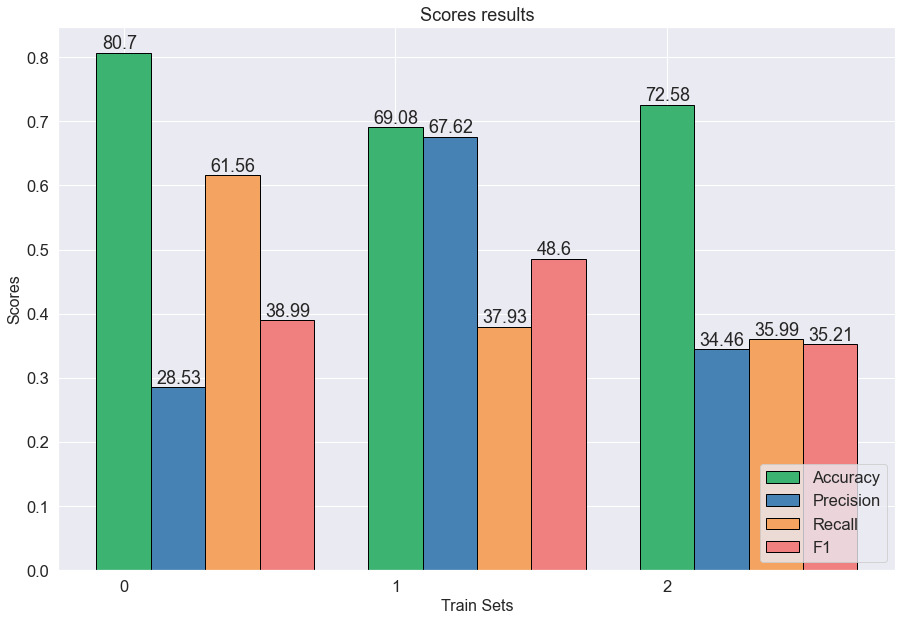

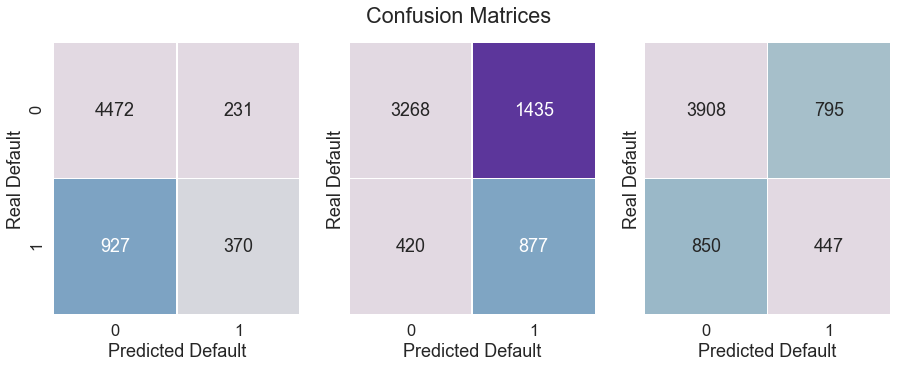

In [130]:
%%time
grid_KNN1 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_KNN1))):
    print("FOR: ", k, " with: ", v[0].shape, v[2].shape)
    grid_KNN1[i] = GridSearchKNN(v[0], v[1], scaler = StandardScaler(), dimRed = PCA(n_components = 2)) #X_train, y_train..
    
    ypred = grid_KNN1[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

In [55]:
# FOR:  X_train upsampled and binary encoded  with:  (30673, 77)
# Best  accuracy  score:  0.8535519074279426
# {'kneighborsclassifier__metric': 'chebyshev', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__weights': 'distance'}
# Scaler:  MinMaxScaler() Dimention reduction:  PCA(n_components=2)
# Accuracy = 0.955
# Precision = 0.925
# Recall = 0.875
# F1 = 0.900

model_verif = make_pipeline(MinMaxScaler(), PCA (n_components = 2), 
                            KNeighborsClassifier(n_neighbors = 29, weights = 'distance', metric = 'chebyshev'))
model_verif.fit(X_train_enc_up, y_train_enc_up)
model_verif.score(X_test_enc_up, y_test_enc_up)


0.8590963139120095

In [56]:
model_verif = make_pipeline(MinMaxScaler(), PCA (n_components = 2), 
                            KNeighborsClassifier(n_neighbors = 29, weights = 'distance', metric = 'chebyshev'))
#model_verif.fit(X_train_enc_up, y_train_enc_up)
score = cross_val_score(model_verif, X_train_enc_up, y_train_enc_up, cv = 5, scoring = "precision").mean()
score2 = cross_val_score(model_verif, X_train_enc_up, y_train_enc_up, cv = 5, scoring = "precision")

print(score, score2)


0.7774111926971097 [0.77758441 0.77758319 0.77878261 0.77677643 0.77632933]


FOR:  X_train binary encoded
Best  f1  score:  0.46436048987951406
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__weights': 'uniform'}
Scaler:  MinMaxScaler() Dimention reduction:  LinearDiscriminantAnalysis()
Accuracy = 0.824
Precision = 0.364
Recall = 0.672
F1 = 0.472

FOR:  X_train downsampled and binary encoded
Best  f1  score:  0.7017666571549958
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__weights': 'uniform'}
Scaler:  MinMaxScaler() Dimention reduction:  LinearDiscriminantAnalysis()
Accuracy = 0.684
Precision = 0.681
Recall = 0.373
F1 = 0.482

FOR:  X_train upsampled and binary encoded
Best  f1  score:  0.8626052799213095
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}
Scaler:  MinMaxScaler() Dimention reduction:  LinearDiscriminantAnalysis()
Accuracy = 0.734
Precision = 0

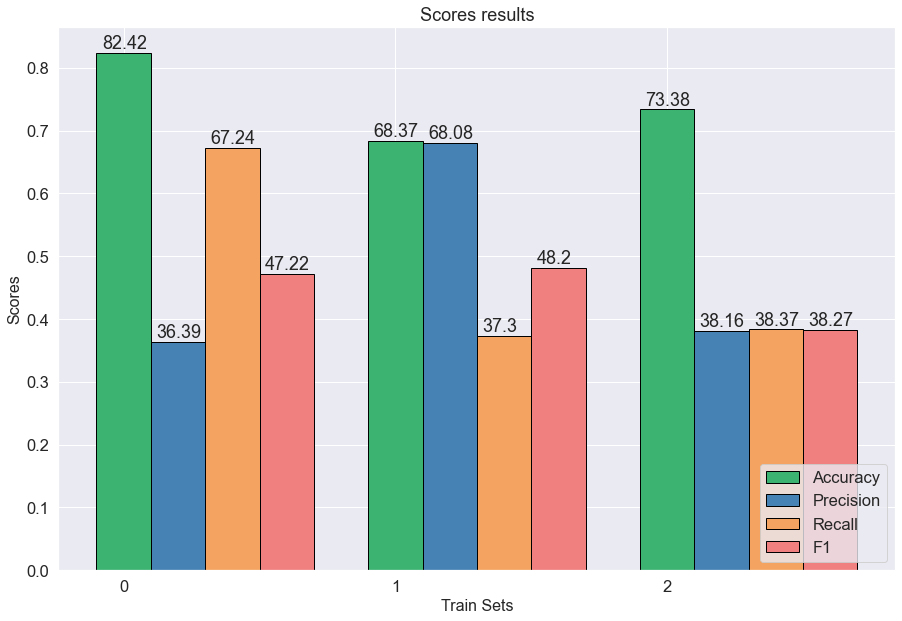

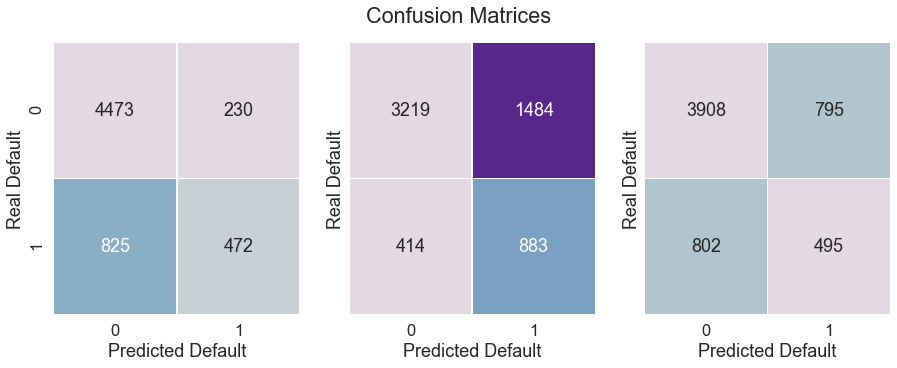

In [132]:
%%time
grid_KNN2 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_KNN2))):
    print("FOR: ", k)
    grid_KNN2[i] = GridSearchKNN(v[0], v[1], dimRed = LDA(), score = 'f1')
    
    ypred = grid_KNN2[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

FOR:  X_train binary encoded
Best  accuracy  score:  0.8168333333333333
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__weights': 'uniform'}
Scaler:  MinMaxScaler() Dimention reduction:  SelectKBest(k=20, score_func=<function chi2 at 0x000001C4214A4940>)
Accuracy = 0.819
Precision = 0.357
Recall = 0.679
F1 = 0.468

FOR:  X_train downsampled and binary encoded
Best  accuracy  score:  0.6697101529288356
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 16, 'kneighborsclassifier__weights': 'uniform'}
Scaler:  MinMaxScaler() Dimention reduction:  SelectKBest(k=20, score_func=<function chi2 at 0x000001C4214A4940>)
Accuracy = 0.692
Precision = 0.622
Recall = 0.781
F1 = 0.692

FOR:  X_train upsampled and binary encoded
Best  accuracy  score:  0.6851573035137829
{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 27, 'kneighborsclassifier__weights': 'distance'}
Scaler: 

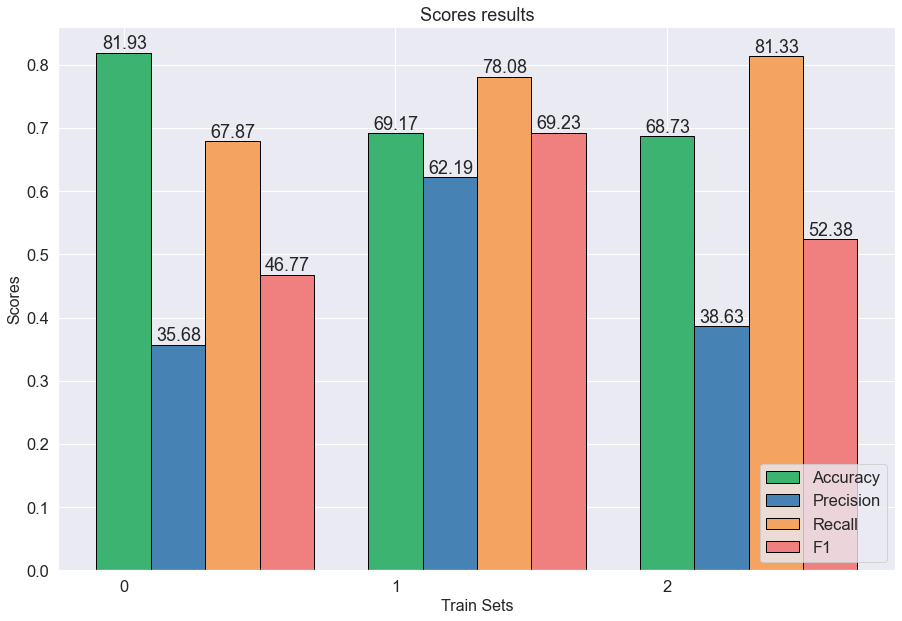

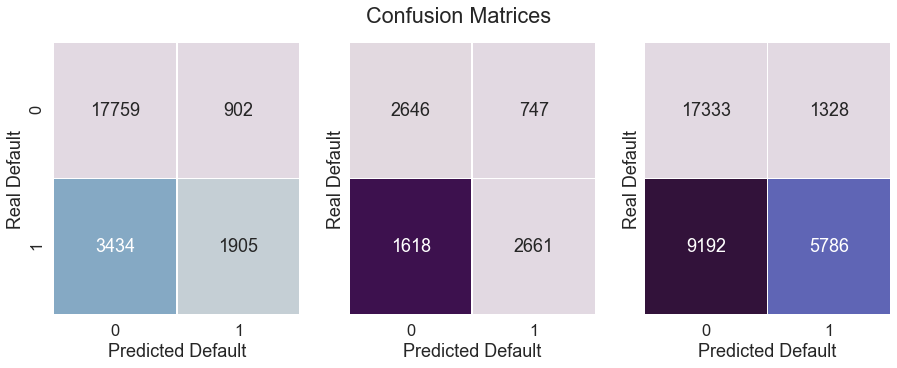

In [133]:
%%time
grid_KNN3 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_KNN3))):
    print("FOR: ", k)
    grid_KNN3[i] = GridSearchKNN(v[0], v[1], dimRed = SelectKBest(chi2, k=20))
    
    ypred = grid_KNN3[i].predict(v[0])
    cm = ConfusionMatrix(v[1], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

0.6348333333333334


array([[3191, 1512],
       [ 679,  618]], dtype=int64)

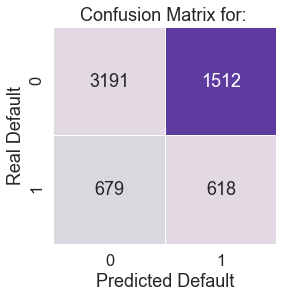

In [134]:
# FOR:  X_train upsampled and binary encoded
# Best  accuracy  score:  0.8535193075909417
# {'kneighborsclassifier__metric': 'chebyshev', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__weights': 'distance'}
# Scaler:  MinMaxScaler() Dimention reduction:  PCA(n_components=2)
# Accuracy = 0.925
# Precision = 0.925
# Recall = 0.875
# F1 = 0.900

pipe = make_pipeline( PCA(n_components = 2), MinMaxScaler(),KNeighborsClassifier(metric = 'chebyshev', 
                                                                                 n_neighbors = 29, weights = 'distance'))
pipe.fit(X_train_up, y_train_up)
print(pipe.score(X_test, y_test))
y_pred = pipe.predict(X_test)
ConfusionMatrix(y_test, y_pred)

---

## 2. Random Forest

In [1]:
%%time
grid_RF1 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_RF1))):
    print("FOR: ", k)
    grid_RF1[i] = GridSearchRF(v[0], v[1], scaler = MinMaxScaler())
    
    ypred = grid_RF1[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

NameError: name 'trainSets' is not defined

FOR:  X_train binary encoded
Best  accuracy  score:  0.7437083333333334
{'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 10}
Scaler:  MinMaxScaler() Dimention reduction:  LinearDiscriminantAnalysis()
Accuracy = 0.743
Precision = 0.369
Recall = 0.399
F1 = 0.383

FOR:  X_train downsampled and binary encoded
Best  accuracy  score:  0.6088390403832352
{'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 10}
Scaler:  MinMaxScaler() Dimention reduction:  LinearDiscriminantAnalysis()
Accuracy = 0.593
Precision = 0.641
Recall = 0.296
F1 = 0.405

FOR:  X_train upsampled and binary encoded
Best  accuracy  score:  0.8669400928729363
{'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 200}
Scaler:  MinMaxScaler() Dimention reduction:  LinearDiscriminantAnalysis()
Accuracy = 0.734
Precision = 0.382
Recall = 0.383
F1 = 0.382

Wall time: 1min 55s


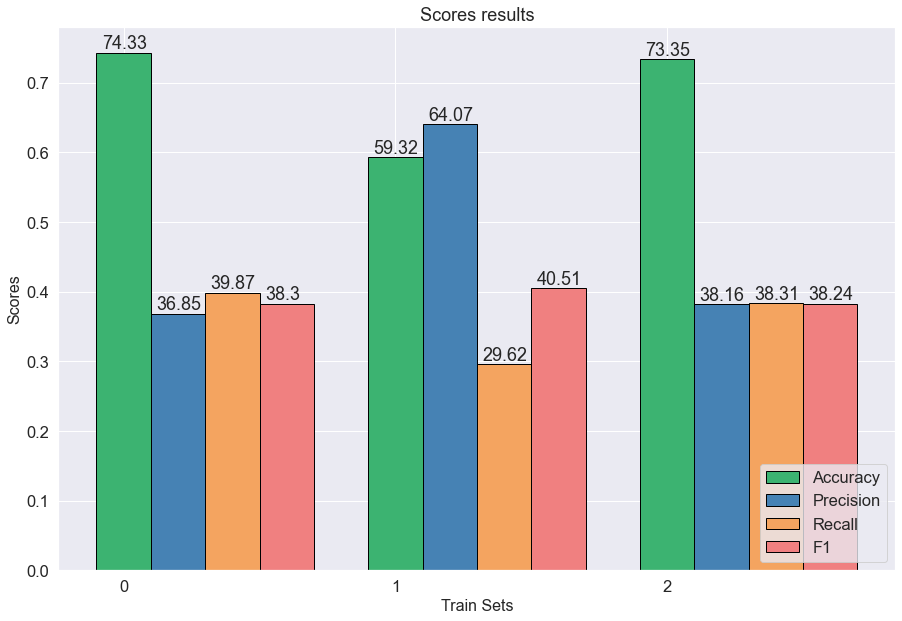

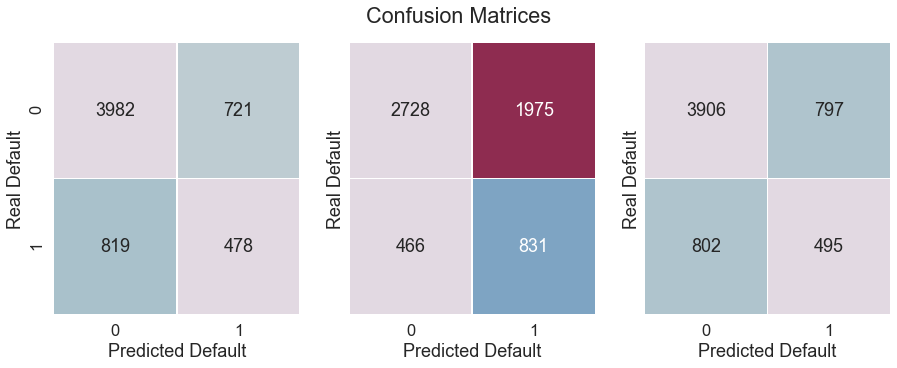

In [136]:
%%time
grid_RF2 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_RF2))):
    print("FOR: ", k)
    grid_RF2[i] = GridSearchRF(v[0], v[1], dimRed = LDA())
    
    ypred = grid_RF2[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

---

## 3. Naives Bayes

FOR:  X_train binary encoded
Best  accuracy  score:  0.80375
{}
Scaler:  MinMaxScaler() Dimention reduction:  PCA(n_components=2)
Accuracy = 0.807
Precision = 0.278
Recall = 0.617
F1 = 0.384

FOR:  X_train downsampled and binary encoded
Best  accuracy  score:  0.6259109267037275
{}
Scaler:  MinMaxScaler() Dimention reduction:  PCA(n_components=2)
Accuracy = 0.691
Precision = 0.551
Recall = 0.360
F1 = 0.435

FOR:  X_train upsampled and binary encoded
Best  accuracy  score:  0.6784983606447265
{}
Scaler:  MinMaxScaler() Dimention reduction:  PCA(n_components=2)
Accuracy = 0.753
Precision = 0.460
Recall = 0.433
F1 = 0.446

Wall time: 2.82 s


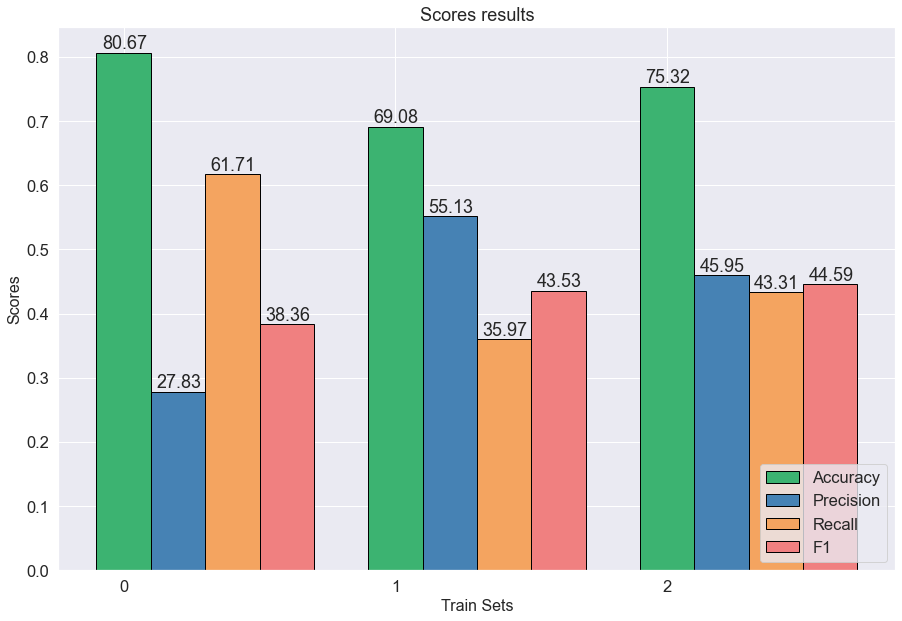

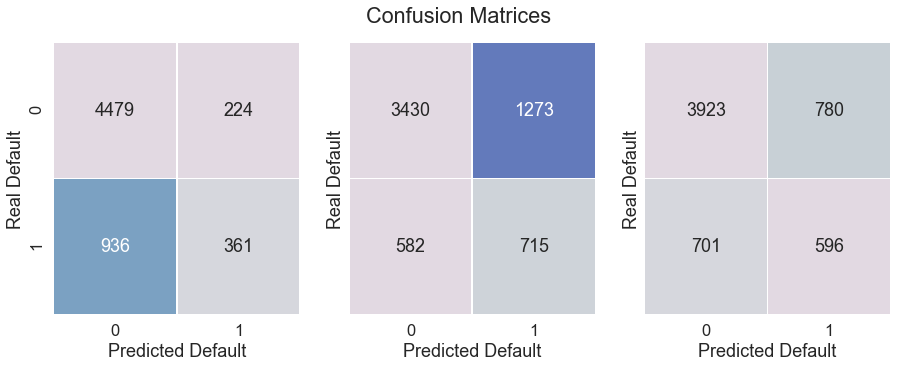

In [137]:
%%time
grid_NB1 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_NB1))):
    print("FOR: ", k)
    grid_NB1[i] = GridSearchNB(v[0], v[1])
    
    ypred = grid_NB1[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

In [138]:
ROC(grid_NB1[0], grid_NB1[0], grid_NB1[0], grid_NB1[0], X_train, y_test)

ValueError: operands could not be broadcast together with shapes (24000,23) (77,) (24000,23) 

In [ ]:
%%time
grid_NB2 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_NB1))):
    print("FOR: ", k)
    grid_NB2[i] = GridSearchNB(v[0], v[1], dimRed = LDA())
    
    ypred = grid_NB2[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

## 4. Logistic Regression

In [ ]:
%%time
grid_LR1 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_LR1))):
    print("FOR: ", k)
    grid_LR1[i] = GridSearchLR(v[0], v[1])
    
    ypred = grid_LR1[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

In [ ]:
%%time
grid_LR2 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_LR2))):
    print("FOR: ", k)
    grid_LR2[i] = GridSearchLR(v[0], v[1], dimRed = LDA())
    
    ypred = grid_LR2[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

---

## 5. SVM

In [ ]:
%%time
grid_SVM1 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_SVM1))):
    print("FOR: ", k)
    grid_SVM1[i] = GridSearchSVM(v[0], v[1])
    
    ypred = grid_SVM1[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

In [ ]:
%%time
grid_SVM2 = [0] * len(trainSets)
accuracy_l = list()
precision_l = list()
recall_l = list()
f1_l = list()
cm_l = list()

for k, v, i in zip(trainSets.keys(), trainSets.values(), range(0, len(grid_SVM2))):
    print("FOR: ", k)
    grid_SVM2[i] = GridSearchSVM(v[0], v[1], dimRed = LDA())
    
    ypred = grid_SVM2[i].predict(v[2])
    cm = ConfusionMatrix(v[3], ypred, k, False)
    accuracy, precision, recall, f1 = ClassificationMetrics(cm)
    
    accuracy_l.append(accuracy)
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    cm_l.append(cm)
    
    print("")

PlotScores2(accuracy_l, precision_l, recall_l,f1_l, cm_l)

---

# === Show results using the best parameters ===

In [ ]:
pd.DataFrame(grid.cv_results_)

In [ ]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [ ]:
pd.DataFrame(grid_KNN_1.cv_results_)[['mean_test_score', 'std_test_score', 'params']]